# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

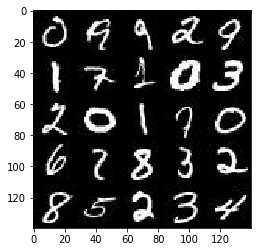

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

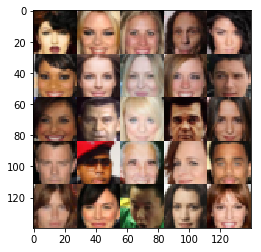

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=3, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
              
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [ ]:
import numpy as np
print(np.random.uniform(0.9,0.99))
print(np.random.uniform(0.01,0.2))

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(g_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(d_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    
    # Initialize variables
    input_real, input_z, lr_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #lr_rate = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                # Convert -0.5 to 0.5 to -1 to 1 for Tanh 
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr_rate : learning_rate})
                #_ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr_rate : learning_rate})
                
                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))   
                    
                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  
        
        # Final Output
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)   
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2500... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 1.2415
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.5733
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.4633


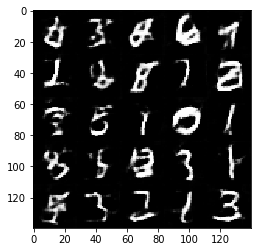

Epoch 1/2... Discriminator Loss: 3.0400... Generator Loss: 0.0695
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 0.9592
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 2.3857
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 0.7484... Generator Loss: 0.9620


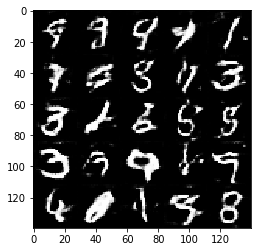

Epoch 2/2... Discriminator Loss: 0.6572... Generator Loss: 1.3627
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 3.9059
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 1.5901


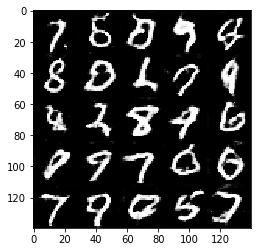

Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.0224
Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 0.9474
Epoch 2/2... Discriminator Loss: 0.3923... Generator Loss: 1.5615


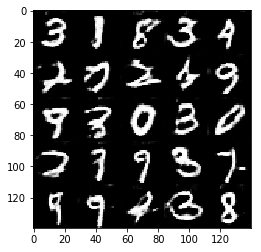

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.9442
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.3629
Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 0.9003... Generator Loss: 1.3244


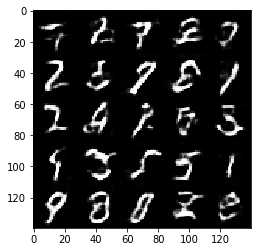

Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 1.7445
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 1.2723
Epoch 1/2... Discriminator Loss: 2.3824... Generator Loss: 0.1660
Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 1.0287
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 0.7452


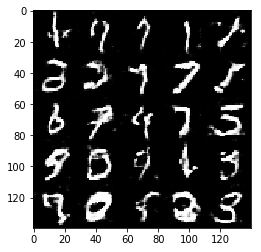

Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 0.8117... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 0.7602... Generator Loss: 1.1418
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 1.4255
Epoch 2/2... Discriminator Loss: 0.4912... Generator Loss: 1.7001


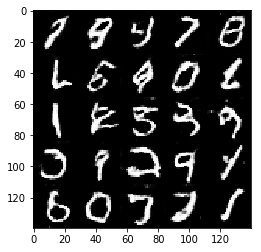

Epoch 2/2... Discriminator Loss: 0.3895... Generator Loss: 1.5867
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.6250
Epoch 2/2... Discriminator Loss: 0.4000... Generator Loss: 1.4339


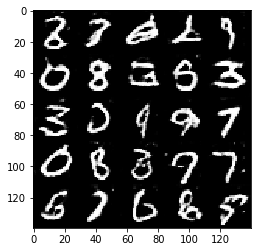

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 1.5786
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.4784
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 2.0432... Generator Loss: 0.1840
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.4864


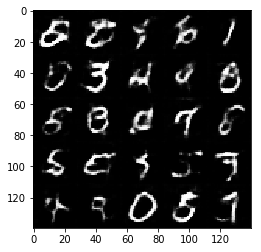

Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 0.9543
Epoch 1/2... Discriminator Loss: 0.6243... Generator Loss: 1.3971
Epoch 1/2... Discriminator Loss: 0.6532... Generator Loss: 1.4427
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 0.9468


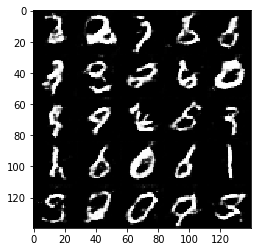

Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.3077
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 0.4871... Generator Loss: 1.8376
Epoch 2/2... Discriminator Loss: 0.5748... Generator Loss: 1.3684
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.4943


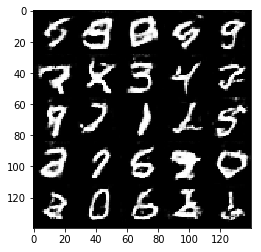

Epoch 2/2... Discriminator Loss: 0.4396... Generator Loss: 1.7949
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 1.5125
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 0.7879


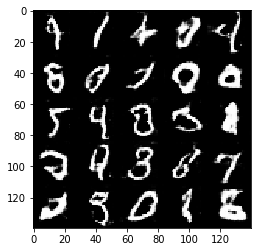

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.5850
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 0.7551... Generator Loss: 1.7395
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.5334


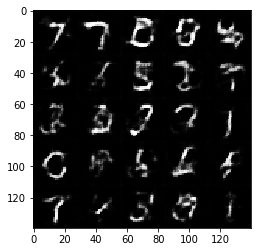

Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.3582
Epoch 1/2... Discriminator Loss: 0.6917... Generator Loss: 1.4863
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 0.7709... Generator Loss: 0.8932


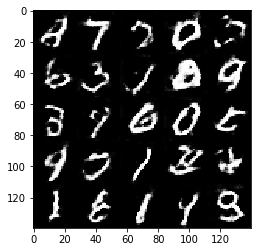

Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.2249
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 0.5892
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 1.3876
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.6054
Epoch 2/2... Discriminator Loss: 1.6471... Generator Loss: 3.2152


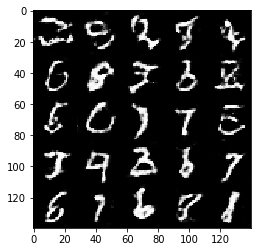

Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 1.0129
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 1.2331
Epoch 2/2... Discriminator Loss: 0.4986... Generator Loss: 1.6204


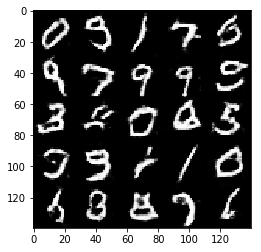

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 0.3310
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 1.7407
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 0.7300... Generator Loss: 0.9680
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 0.9461


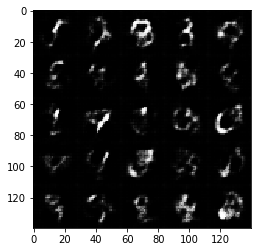

Epoch 1/2... Discriminator Loss: 0.7313... Generator Loss: 1.2984
Epoch 1/2... Discriminator Loss: 0.7634... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.5713
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 0.8999


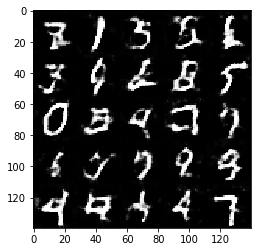

Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 1.0502
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 0.7358
Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 1.2095
Epoch 2/2... Discriminator Loss: 0.5077... Generator Loss: 1.6484
Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.1051


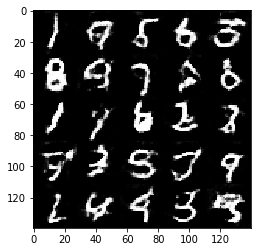

Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 1.2422
Epoch 2/2... Discriminator Loss: 2.0977... Generator Loss: 3.1392
Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 1.6274


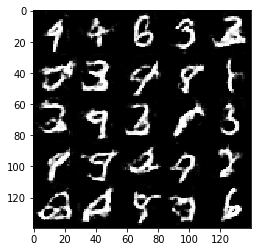

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## Experimental Results

As you can see from the above parameter combinations, it looks like with batch_size = 64, z_dim = 100 and beta1 = 0.5 the best learning_rate = 0.0004.  I'll apply this combination to the Celebrity Photos GANs.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 1.4953
Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 1.1213
Epoch 1/2... Discriminator Loss: 0.7033... Generator Loss: 1.4556
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 0.7870... Generator Loss: 1.6853


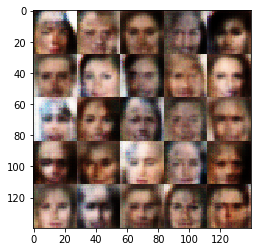

Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.6987
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 0.4892
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 2.7097
Epoch 1/2... Discriminator Loss: 1.8754... Generator Loss: 1.2178


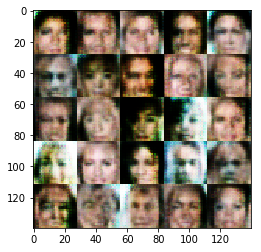

Epoch 1/2... Discriminator Loss: 0.1017... Generator Loss: 3.1560
Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 2.4292
Epoch 1/2... Discriminator Loss: 2.5525... Generator Loss: 2.6623
Epoch 1/2... Discriminator Loss: 0.6446... Generator Loss: 1.2502
Epoch 1/2... Discriminator Loss: 0.2429... Generator Loss: 2.3584


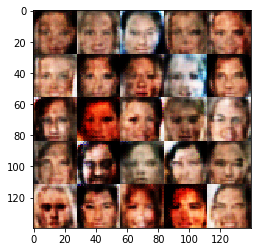

Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 2.1268
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.7630
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 0.3830
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 3.1488
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 0.5813


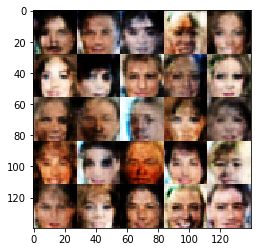

Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 1.6836
Epoch 1/2... Discriminator Loss: 0.1933... Generator Loss: 2.4225
Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 1.3328
Epoch 1/2... Discriminator Loss: 1.9329... Generator Loss: 0.2047


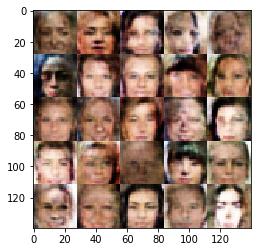

Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.5576
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 1.4223
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.5556
Epoch 1/2... Discriminator Loss: 0.3562... Generator Loss: 2.7714
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.4614


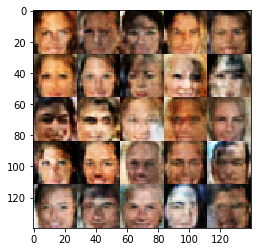

Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.3418
Epoch 2/2... Discriminator Loss: 0.6003... Generator Loss: 1.0928
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.3814
Epoch 2/2... Discriminator Loss: 2.5575... Generator Loss: 0.1286
Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 3.2594


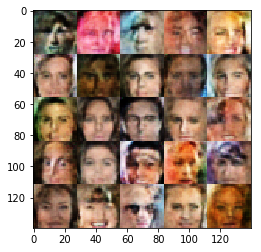

Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 0.3401... Generator Loss: 1.9846
Epoch 2/2... Discriminator Loss: 0.5111... Generator Loss: 1.9117
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 2.0529
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.5498


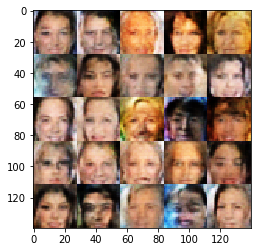

Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 1.0234... Generator Loss: 1.2803
Epoch 2/2... Discriminator Loss: 0.4891... Generator Loss: 1.7835
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 0.9576... Generator Loss: 0.9467


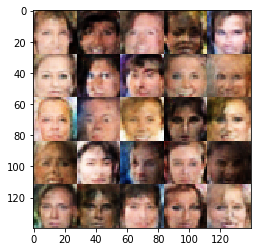

Epoch 2/2... Discriminator Loss: 0.3004... Generator Loss: 2.1733
Epoch 2/2... Discriminator Loss: 0.2910... Generator Loss: 2.6617
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.4026
Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.0026


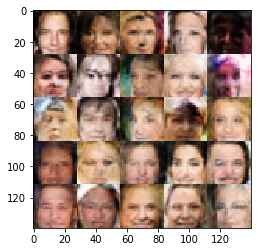

Epoch 2/2... Discriminator Loss: 1.6140... Generator Loss: 2.9198
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 1.4470
Epoch 2/2... Discriminator Loss: 1.0206... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 1.6686... Generator Loss: 0.2833


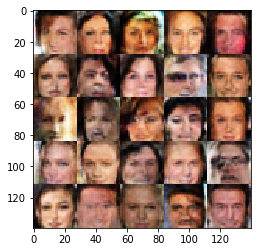

Epoch 2/2... Discriminator Loss: 0.5151... Generator Loss: 1.5127
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 1.4919
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 1.7645


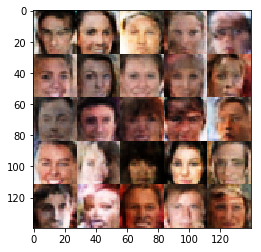

Epoch 2/2... Discriminator Loss: 1.5337... Generator Loss: 2.7099
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.6065
Epoch 2/2... Discriminator Loss: 0.6634... Generator Loss: 1.0641


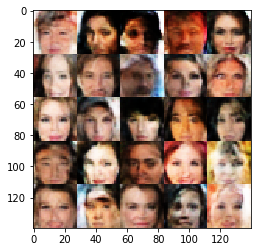

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.